# Resolving Ambiguity in Prepositional Phrase Attachment

The problem of resolving ambiguity in prepositional phrase attachment is one that remains largely unsolved in NLP, and one that pre-trained language models such as BERT will likely not be of much help with. This notebook shows results of predicting prepositional phrase attachments across a subset of the NLVR2 dataset which has been annotated, leveraging a pre-trained language model commonly known as "BERT" (cite). 

We trained an SVM classifier from the output (hidden layers) of the large uncased model from BERT with whole word masking. The results are presented in terms of Cohen's kappa score and F1 score. 

In [1]:
from IPython.display import Image

# Preliminary Steps

In [2]:
# conda create -n python=3.7 ...
# pip install transformers... 

In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from collections import Counter
from operator import itemgetter

In [4]:
from generator import HuggingFaceGenerator, MaskedPrepGenerator, SpacyModel

In [5]:
np.random.seed(91768)

## Load Dataset (train/test)

In [6]:
datadir = "data"
outputdir = "."

In [7]:
train_data = json.load(open('{}/ppa_train.json'.format(datadir)))
labels_train = [instance['label'] for instance in train_data]

test_data = json.load(open('{}/ppa_test.json'.format(datadir)))
labels_test = [instance['label'] for instance in test_data]

## Using BERT Language Model
We load a pre-trained model from BERT and use it to generate instances for model training. 

In [8]:
bert_model_name = "bert-large-uncased-whole-word-masking"
hf_generator = HuggingFaceGenerator(bert_model_name)

## Transform Dataset (or reload)

In [9]:
train_feature_file = "{}/hf_train.csv".format(outputdir)
test_feature_file = "{}/hf_test.csv".format(outputdir)

In [10]:
if os.path.exists(train_feature_file):
    hf_train = pd.read_csv(train_feature_file, header=None)
else:
    hf_train = hf_generator.generate_dataset(train_data)
    pd.DataFrame(hf_train).to_csv(train_feature_file, header=False,index=False)

In [11]:
if os.path.exists(test_feature_file):
    hf_test = pd.read_csv(test_feature_file, header=None)
else:
    hf_test = hf_generator.generate_dataset(test_data)
    pd.DataFrame(hf_test).to_csv(test_feature_file, header=False,index=False)

# Model Training

In [12]:
clfhf = svm.SVC(gamma=0.0001, C=100., random_state=91768)
clfhf.fit(hf_train, labels_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=91768, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
preds_test_hf = clfhf.predict(hf_test)

In [14]:
print(sklearn.metrics.classification_report(labels_test, preds_test_hf, digits=3))

              precision    recall  f1-score   support

           N      0.875     0.946     0.909       111
           O      0.667     0.400     0.500        10
           V      0.742     0.639     0.687        36

    accuracy                          0.841       157
   macro avg      0.761     0.662     0.699       157
weighted avg      0.831     0.841     0.832       157



### without 'O'(ther) classification

In [15]:
nvi = [i for i,lbl in enumerate(labels_train) if lbl in ['N','V']]

In [16]:
labels_train_NV = [lbl for lbl in labels_train if lbl in ['N','V']]

In [17]:
hf_train_NV = hf_train.to_numpy()[nvi]
#hf_generator.generate_dataset([td for td,lbl in zip(train_data,labels_train) if lbl in ['N','V']])

In [18]:
hf_train_NV.shape

(435, 16384)

In [19]:
nvi_test = [i for i,lbl in enumerate(labels_test) if lbl in ['N','V']]

In [20]:
hf_test_NV = hf_test.to_numpy()[nvi_test]
#hf_generator.generate_dataset([td for td,lbl in zip(test_data,labels_test) if lbl in ['N','V']])

In [21]:
labels_test_NV = [lbl for lbl in labels_test if lbl in ['N','V']]

In [22]:
clfhf2 = svm.SVC(gamma=0.0001, C=100., random_state=91768)
clfhf2.fit(hf_train_NV, labels_train_NV)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=91768, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
preds_test_hf2 = clfhf2.predict(hf_test_NV)

In [24]:
confusion_matrix(labels_test, preds_test_hf)

array([[105,   0,   6],
       [  4,   4,   2],
       [ 11,   2,  23]])

In [25]:
confusion_matrix(labels_test_NV, preds_test_hf2)

array([[104,   7],
       [ 12,  24]])

In [26]:
print(sklearn.metrics.classification_report(labels_test_NV, preds_test_hf2, digits=3))

              precision    recall  f1-score   support

           N      0.897     0.937     0.916       111
           V      0.774     0.667     0.716        36

    accuracy                          0.871       147
   macro avg      0.835     0.802     0.816       147
weighted avg      0.867     0.871     0.867       147



## Applying BERT to the same dataset for the masked prep task... 

In [27]:
mpgen = MaskedPrepGenerator(bert_model_name)

In [28]:
mplabels,mppredictions=mpgen.evaluate_dataset(test_data,use_cuda=True)

(82 correct / 100 total)
(160 correct / 200 total)
(236 correct / 300 total)


In [29]:
accuracy_score(mplabels,mppredictions)

0.7849462365591398

In [30]:
kappa(mplabels, mppredictions)

0.7426407001279878

In [31]:
sklearn.metrics.classification_report(mplabels, mppredictions, digits=3, output_dict=True, zero_division=0)['weighted avg']['f1-score']

0.8111697864740477

## Error Analysis

In [32]:
get_4tpl = lambda x : (x['V']['lemma'],x['N']['lemma'],x['P']['lemma'],x['N2']['lemma'])

In [33]:
spacy_model = SpacyModel()

In [34]:
spacy_preds_train = [spacy_model.predict(t) for t in train_data]

In [35]:
train_tuples = [get_4tpl(td) for td in list(train_data)]
test_tuples = [get_4tpl(td) for td in list(test_data)]

In [36]:
confusion_matrix(labels_test,preds_test_hf,labels=['N','O','V'])

array([[105,   0,   6],
       [  4,   4,   2],
       [ 11,   2,  23]])

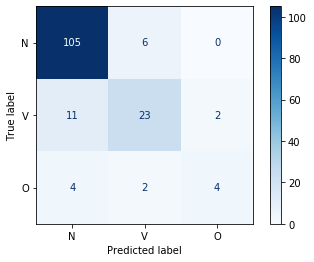

In [37]:
plot_confusion_matrix(clfhf, hf_test, labels_test, labels=['N','V','O'], values_format='d', cmap=plt.cm.Blues)

In [38]:
errors = [(i,lbl,pred) for i,(lbl,pred) in enumerate(zip(labels_test,preds_test_hf)) if not lbl==pred]

In [39]:
def get_err_info(err,data):
    (i,lbl,pred)=err
    td=data[i]
    #print(td['sentence_text'])
    return ((i,*get_4tpl(td),lbl,pred,td['sentence_text']))

In [40]:
error_tuples=[]
for err in errors: 
    # Exclude 'other' cases for now
    if 'O' in err:
        continue
    error_tuples.append(get_err_info(err,test_data))

In [41]:
df = pd.DataFrame(error_tuples, columns=['i','V','N1','P','N2','label','pred','sentence_text'])

In [42]:
df

,i,V,N1,P,N2,label,pred,sentence_text
0,0,be,dog,in,pair,V,N,There are three chow dogs in the image pair.
1,20,wear,ear,on,head,N,V,A girl in long one piece pajamas is wearing mo...
2,28,feature,shape,above,shape,V,N,Each dispenser has a circle shape and an upsid...
3,57,be,dog,in,image,N,V,There is exactly one dog in the right image.
4,64,be,bottle,with,lid,N,V,There is one bottle with a lid and one bottle ...
5,67,have,door,in,section,N,V,Two tall narrow cabinets have at least three u...
6,72,put,leg,on,fence,V,N,putting their right leg high up on a fence.
7,75,have,toy,in,front,V,N,At least one of the dogs has a small toy in fr...
8,78,include,wand,to,right,V,N,The combined images include an uncapped lipsti...
9,83,be,awning,over,machine,V,N,There is an awning over the machines in one of...


In [43]:
# Not sure:
# There are at least 3 deer in a tree...
# There is a dog on a green rug. 
# also not sure what to do about 'next to'

In [44]:
# Some instances seem to be labeled incorrectly
wrong_label_indices = [1,3,5,12,15]

In [45]:
new_test_labels = [lbl for lbl in labels_test]
for i in df.to_numpy()[wrong_label_indices,0]:
    new_test_labels[i] = 'V'

## Analyze train/dev

In [46]:
spacy_preds = [spacy_model.predict(t) for t in test_data]

In [47]:
classifiers = ['all_noun','spacy','bert']

In [48]:
test_preds = [['N' for i in range(len(labels_test))], spacy_preds, preds_test_hf]

In [49]:
class_reports = {cl: sklearn.metrics.classification_report(labels_test, preds, digits=3, output_dict=True, zero_division=0) 
                 for (cl,preds) in zip(classifiers, test_preds)}

In [50]:
pd.DataFrame([[c, class_reports[c]['weighted avg']['f1-score']] for c in classifiers], columns=['classifier','weighted avg f1-score'])

,classifier,weighted avg f1-score
0,all_noun,0.585655
1,spacy,0.722477
2,bert,0.832010


In [51]:
print(sklearn.metrics.classification_report(labels_test, ['N' for i in range(len(labels_test))], digits=3,zero_division=0))

              precision    recall  f1-score   support

           N      0.707     1.000     0.828       111
           O      0.000     0.000     0.000        10
           V      0.000     0.000     0.000        36

    accuracy                          0.707       157
   macro avg      0.236     0.333     0.276       157
weighted avg      0.500     0.707     0.586       157



In [52]:
print(sklearn.metrics.classification_report(labels_test, spacy_preds, digits=3))

              precision    recall  f1-score   support

           N      0.798     0.928     0.858       111
           O      0.500     0.800     0.615        10
           V      0.667     0.222     0.333        36

    accuracy                          0.758       157
   macro avg      0.655     0.650     0.602       157
weighted avg      0.749     0.758     0.722       157



In [53]:
print(sklearn.metrics.classification_report(labels_test, preds_test_hf, digits=3))

              precision    recall  f1-score   support

           N      0.875     0.946     0.909       111
           O      0.667     0.400     0.500        10
           V      0.742     0.639     0.687        36

    accuracy                          0.841       157
   macro avg      0.761     0.662     0.699       157
weighted avg      0.831     0.841     0.832       157



In [60]:
print(sklearn.metrics.classification_report(labels_train, spacy_preds_train, digits=3))

              precision    recall  f1-score   support

           N      0.780     0.855     0.816       331
           O      0.481     0.703     0.571        37
           V      0.455     0.240     0.314       104

    accuracy                          0.708       472
   macro avg      0.572     0.599     0.567       472
weighted avg      0.685     0.708     0.686       472



In [54]:
def collect_labels(train_tuples, train_labels):
    ngram_labels = {}
    probs = {}
    for tpl,lbl in zip(train_tuples,train_labels):
        triples = [tpl[:3],(tpl[0],*tpl[2:]),tpl[1:]]
        doubles = [(tpl[0],tpl[2]),tpl[1:2],tpl[2:]]
        singles = [tuple([t]) for t in tpl]
        subtuples = [(tpl)] + triples + doubles + singles
        for subtpl in subtuples:
            if subtpl not in ngram_labels:
                ngram_labels[subtpl] = []
            ngram_labels[subtpl].append(lbl)
    return ngram_labels

In [55]:
ngram_labels=collect_labels(train_tuples, labels_train)

In [56]:
support = []
for ngram, labels in ngram_labels.items():
    total = len(labels)
    proportion = len([lbl for lbl in labels if lbl=='N'])/total
    support.append((proportion, total, ngram))

In [58]:
insights = sorted(support, key=itemgetter(1), reverse=True)

In [59]:
rules = {}
for (proportion,total,ngram) in insights: 
    if abs(proportion-0.5)<0.38:
        continue
    if total<9:
        continue
    print("{}: {:.1f}% (N={})".format(ngram,100.0*proportion,total))
    if proportion>0.5:
        rules[ngram]= "N"
    else:
        rules[ngram]= "V"

('of',): 88.3% (N=128)
('with',): 94.2% (N=121)
('show',): 92.3% (N=91)
('contain',): 95.8% (N=72)
('number',): 100.0% (N=60)
('in', 'image'): 11.1% (N=54)
('contain', 'of'): 97.8% (N=45)
('show', 'with'): 97.1% (N=35)
('be', 'in', 'image'): 5.9% (N=34)
('contain', 'number', 'of'): 100.0% (N=30)
('show', 'of'): 95.0% (N=20)
('row',): 100.0% (N=19)
('include',): 94.4% (N=18)
('feature', 'with'): 100.0% (N=16)
('be', 'with'): 93.8% (N=16)
('contain', 'with'): 100.0% (N=15)
('be', 'dog', 'in'): 10.0% (N=10)
('dog', 'in', 'image'): 10.0% (N=10)
('color',): 100.0% (N=10)
('be', 'in', 'total'): 0.0% (N=9)
('in', 'total'): 0.0% (N=9)
('of', 'image'): 11.1% (N=9)
('balloon',): 100.0% (N=9)
